## _Model using **Residual Learning** and **Batch Normalization**_

### Import Libraries

In [1]:
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
from keras.layers import Dropout
from tensorflow import keras

import matplotlib.pyplot as plt

2022-04-11 13:33:11.905577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 13:33:11.905609: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data augmentation for bigger sample space

In [2]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2022-04-11 13:38:10.100890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-11 13:38:10.100927: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-11 13:38:10.100948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux): /proc/driver/nvidia/version does not exist
2022-04-11 13:38:10.101186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model Architecture

In [3]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.Add()([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_batchNormalize = keras.Model(inputs, outputs)

### Load and preprocess data

In [4]:
# images path
import os, pathlib, shutil
new_img_path = pathlib.Path("../dataset/facemask_images_small")

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory=new_img_path / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    directory=new_img_path / "val",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    directory=new_img_path / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 900 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 260 files belonging to 2 classes.


In [6]:
for data_batch, labels_batch in train_dataset:
    print("Data batch shape: ", data_batch.shape)

    print("Labels batch shape: ", labels_batch.shape)
    break

Data batch shape:  (32, 180, 180, 3)
Labels batch shape:  (32,)


### Model Summary

In [7]:
model_batchNormalize.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 176, 176, 32  2400        ['rescaling[0][0]']          

### Model Compilation and Training

In [9]:
model_batchNormalize.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="../models/checkpoints/facemask_image_clf_BN.keras",
        save_best_only=True,
        monitor='val_accuracy'
    )
]

In [11]:
history = model_batchNormalize.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/20
29/29 [==============================] - 109s 4s/step - loss: 0.6593 - accuracy: 0.6144 - val_loss: 0.6793 - val_accuracy: 0.5900
Epoch 2/20
29/29 [==============================] - 104s 4s/step - loss: 0.2164 - accuracy: 0.9356 - val_loss: 0.7219 - val_accuracy: 0.5000
Epoch 3/20
29/29 [==============================] - 106s 4s/step - loss: 0.1137 - accuracy: 0.9689 - val_loss: 0.7806 - val_accuracy: 0.5000
Epoch 4/20
29/29 [==============================] - 107s 4s/step - loss: 0.0369 - accuracy: 0.9900 - val_loss: 0.7065 - val_accuracy: 0.5000
Epoch 5/20
29/29 [==============================] - 106s 4s/step - loss: 0.0222 - accuracy: 0.9944 - val_loss: 0.8700 - val_accuracy: 0.5000
Epoch 6/20
29/29 [==============================] - 109s 4s/step - loss: 0.0270 - accuracy: 0.9911 - val_loss: 0.7278 - val_accuracy: 0.5000
Epoch 7/20
29/29 [==============================] - 108s 4s/step - loss: 0.0309 - accuracy: 0.9900 - val_loss: 0.7689 - val_accuracy: 0.5000
Epoch 8/20
29

In [12]:
test_model = keras.models.load_model("../models/checkpoints/facemask_image_clf_BN.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss},Test Accuracy: {test_acc}")

9/9 [==============================] - 6s 628ms/step - loss: 0.0226 - accuracy: 0.9923
Test Loss: 0.02262164279818535,Test Accuracy: 0.9923076629638672


### Plotting Model **Performance Curves**

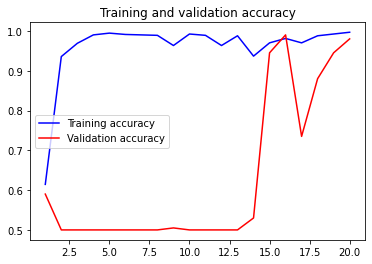

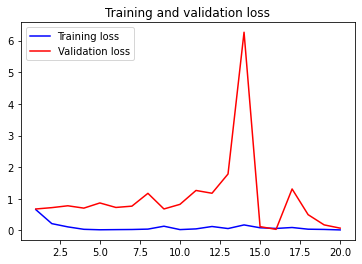

In [13]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy,color='blue', label="Training accuracy")
plt.plot(epochs, val_accuracy, color='red', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, color='blue', label="Training loss")
plt.plot(epochs, val_loss, color='red', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model_batchNormalize.save("./facemask_clf_BN.h5", history)